In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from __future__ import print_function
import argparse
import pandas as pd
from shapely.geometry import Polygon


import sys
sys.path.insert(1, '/media/leandro/Volumen1TB1/Alt Atlas/Image_analysis')

import src.Upload_images as ui
import src.Filtering as F
import src.Data_extraction as de
import src.Data_processing as dp
import src.plotting_visualization as pv
import src.ROI_manual_selector as rms

/home/leandro/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 64
    ksize = 3  # The local area to evaluate
    sigma = 5.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [5]:
def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
 
#The line below is necessary to show Matplotlib's plots inside a Jupyter Notebook
%matplotlib inline
 
from matplotlib import pyplot as plt
 
#Use this helper function if you are working in Jupyter Lab
#If not, then directly use cv2.imshow(<window name>, <image>)
 
def showimage(myimage, figsize=[10,10]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

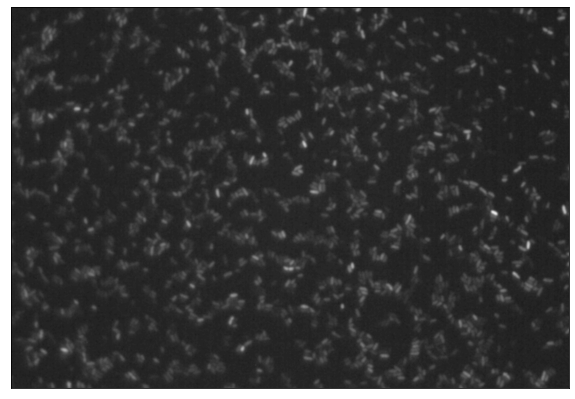

In [11]:
# We create our gabor filters, and then apply them to our image
gfilters = create_gaborfilter()
image_g = apply_filter(image2, gfilters)
 
showimage(image_g)

% of cells area: Project_Image003NC_UCMSC_P5_SS High Glucose.jpg 68.18773333333333
118
0.8209081023591012
0.658609633525634
0.8150298514836556
0.7361055266098074
0.6141959270759758
0.8024045751439794
0.7634397986030298
0.8209081023591012
0.5491855033850147
0.8150298514836556
0.2780077870676115
0.17582555392002883
0.8190725777524535
0.8162545885173853
0.8209081023591012
0.6764310144435278
0.5483490529792459
0.10416787778305729
0.3309798441990726
0.8134763063683347
0.7789998809173453
0.8319552176421404
0.6918325748559079
0.26947714625614544
0.6978193227890838
0.21961154802209926
0.8209081023591012
0.0980756499002886
0.8209081023591012
0.8209081023591012
0.5183913992790529
0.8203551467543069
0.8241471098408206
0.8209081023591012
0.05119445108263595
0.26753823807065735
0.10487179820245068
0.8209081023591012
0.6551398387173525
0.5136327857266736
0.8209081023591012
0.8209081023591012
0.323693661590558
0.4845170867910686
0.806423516080803
0.8209081023591012
0.7666242833515682
0.30523794344359

% of cells area: Project_Image001 NC_UCMSC_P5_SS High Glucose.jpg 69.75733333333334
96
0.6834773403708566
0.701066597618476
0.7304961487819333
0.8203551467543069
0.20482839804975927
0.8203551467543069
0.8320251534895577
0.8203551467543069
0.8203551467543069
0.8209081023591012
0.14351121251854956
0.8209081023591012
0.08382424220703236
0.034794928971299745
0.8203551467543069
0.08818413557297555
0.8209081023591012
0.5443483680612035
0.811820794411073
0.33186422342388944
0.8209081023591012
0.7539822368615503
0.46124854914789837
0.8209081023591012
0.8209081023591012
0.8136744651246296
0.22567020495912576
0.6675887789606059
0.6505828928128173
0.806423516080803
0.1504323383684959
0.16157406552294784
0.8209081023591012
0.46371660201677467
0.779953198013902
0.8209081023591012
0.17127532172158663
0.08149169151584668
0.31370558325734804
0.30098550470457736
0.5110009782830682
0.2389900653056697
0.8150298514836556
0.019129323475113327
0.8228404387879733
0.13218417544698174
0.8319552176421404
0.6712

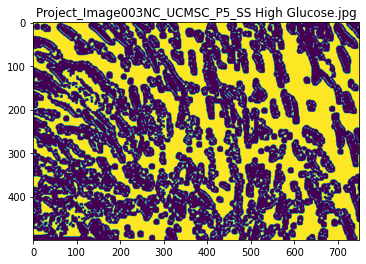

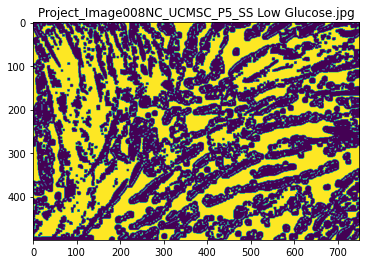

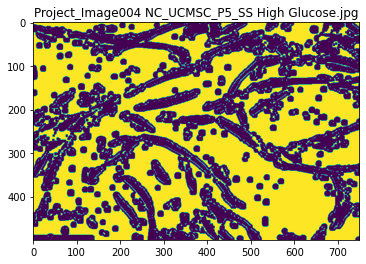

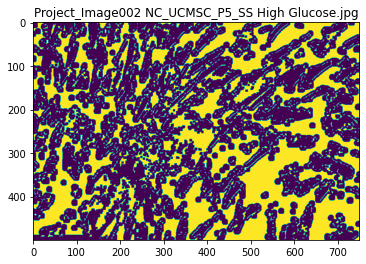

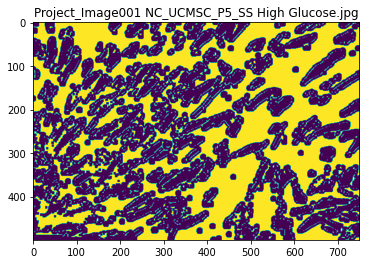

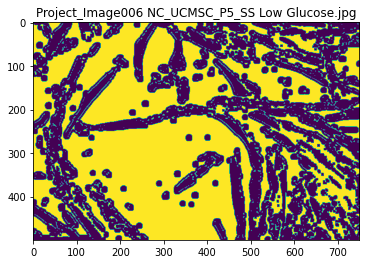

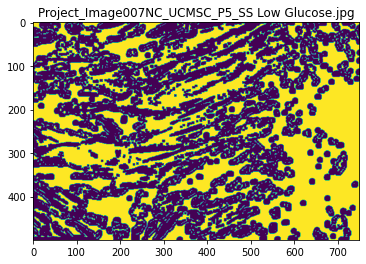

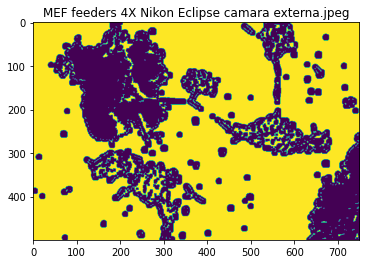

In [12]:
path = '/media/leandro/Volumen1TB1/Alt Atlas/images/Human Embryonic Stem Cells and Human Induced Pluripotent Stem Cell Images/Cells/'
arr = os.listdir(path)
for photo in arr:
    img = ui.readimages_asmatrix(path + photo)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize (img,(750,500), interpolation = cv2.INTER_AREA)
    mask = dp.binary_mask(img,0.1,k_size=3,iterations=2)
    n_white_pix = np.sum(mask == 255)
    print('% of cells area:', photo, n_white_pix*100/mask.size)
    filtered = F.image_filtration (mask, 5, 75)
#         pv.display_image(filtered, photo)
    contours = de.find_contours(filtered) # Obtains elements by contours
    print(len(contours))
    area = []
    for i in range(len(contours)):
        area.append(cv2.contourArea(contours[i]))
        ratio = 4 * np.pi * cv2.contourArea(contours[i]) / (cv2.arcLength(contours[i],True)**2 )
        print(ratio)
    print(photo,sum(area))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(photo)
    plt.imshow(cv2.drawContours(mask, contours, -1, (0,255,0), 3))
#     fig1 = plt.figure()
#     plt.hist(img.ravel(),256,[0,256])

In [13]:
path = '/home/lean/Documentos/Lean/Alt Atlas/Photos/PRIMARY CELL WHARTON_S JELLY MSC  IMAGES FROM HUMAN-PREVIOUS WORK OF DR. SENEM SIMSEK/'
arr = os.listdir(path)
for photo in arr:
    img = cv2.imread(path + photo)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     gray = cv2.resize (gray,(750,500), interpolation = cv2.INTER_AREA)

    # Threshold for mask
    # Dealing with sub figures...
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    gray_1D = gray.ravel()<250 
    gray1D_filtered = gray.ravel()[gray_1D]

    
    threshold = np.quantile(gray1D_filtered,0.23)
    max_value = np.quantile(gray1D_filtered,0.95)
    print(threshold,max_value)
    _, mask = cv2.threshold(gray, thresh=160, maxval=max_value, type=cv2.THRESH_BINARY)

    # The kernel to be used for dilation purpose
    kernel = np.ones((5, 5), np.uint8)
    Mask = cv2.erode(mask, kernel)
#     Mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Inverting the mask by
    # performing bitwise-not operation
    Mask = cv2.bitwise_not(Mask)
    # Printing % of cells area
    n_white_pix = np.sum(Mask == 255)
    print('% of cells area:', photo, n_white_pix*100/Mask.size)
    
    # Displaying the image
    plt.imshow(Mask,'gray')

FileNotFoundError: [Errno 2] No such file or directory: '/home/lean/Documentos/Lean/Alt Atlas/Photos/PRIMARY CELL WHARTON_S JELLY MSC  IMAGES FROM HUMAN-PREVIOUS WORK OF DR. SENEM SIMSEK/'

In [ ]:
path = '/media/leandro/Volumen1TB1/Lean/Patricio Sobrero/'
img = cv2.imread(path + '6_CHA0_NYB_4.tif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.resize (img,(750,500), interpolation = cv2.INTER_AREA)
mask = dp.binary_mask(img,0.1,k_size=3,iterations=2)
filtered = F.image_filtration (mask, 3, 70)
contours = de.find_contours(filtered) # Obtains elements by contours
print(len(contours))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(photo)
plt.imshow(256-mask,'gray')

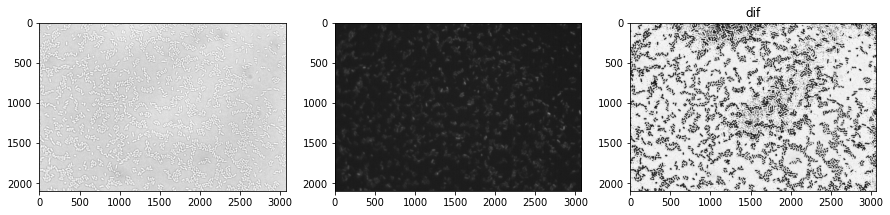

In [14]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.title('dif')
axs[0].imshow(image1,cmap='gray', vmin=0, vmax=255)
axs[1].imshow(image2,cmap='gray', vmin=0, vmax=255)
axs[2].imshow(image1+image2,cmap='gray', vmin=0, vmax=255)

In [19]:
image1+image2

array([[252, 248, 236, ...,   1, 253, 250],
       [249, 244, 235, ...,   0, 253, 252],
       [242, 238, 231, ..., 255, 254, 254],
       ...,
       [ 27,  27,  27, ..., 251, 247, 246],
       [ 28,  28,  28, ..., 252, 250, 250],
       [ 29,  29,  29, ..., 254, 255, 255]], dtype=uint8)

2
3
4
5
6
7
8
9
10


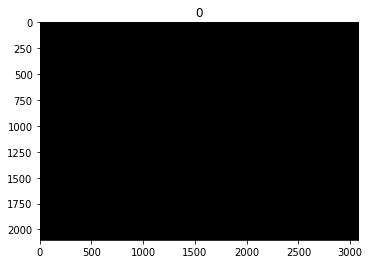

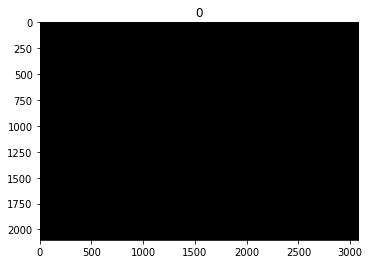

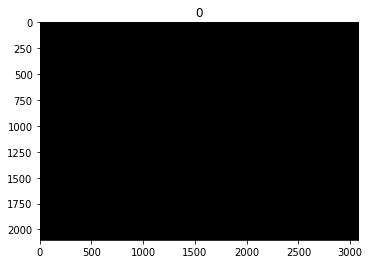

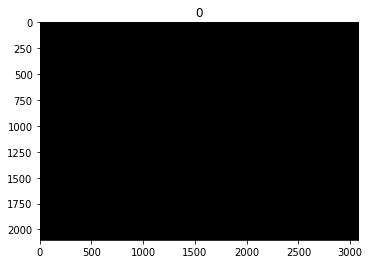

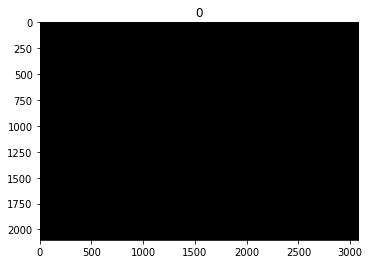

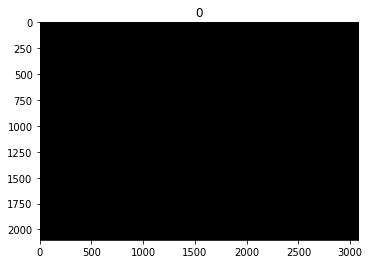

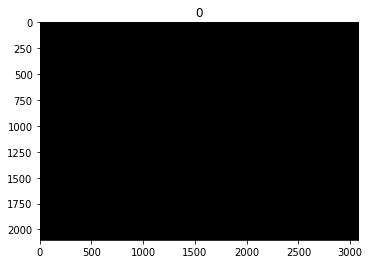

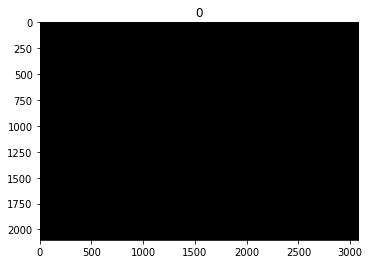

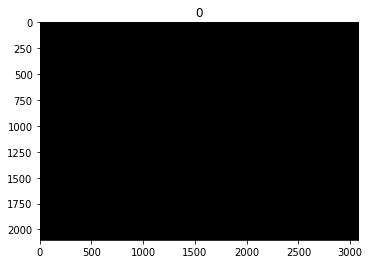

In [28]:
for i in np.arange (2, 11):
    print (i)
    mask = cv2.Canny(255-image1+image2, 10, i*10, 100)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    contours = de.find_contours(mask) # Obtains elements by contours
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(len(contours))
    plt.imshow(mask,cmap='gray')
#     plt.imshow(cv2.drawContours(mask, contours, 1, (0,255,0), 3))

In [ ]:
plt.imshow(cv2.drawContours(img, contours, -1, (0,255,0), 3))

In [ ]:
import numpy as np
import argparse
import cv2
import sys

target = cv2.imread('/media/leandro/Volumen1TB1/Alt Atlas/images/Human Embryonic Stem Cells and Human Induced Pluripotent Stem Cell Images/Cells/Project_Image001 NC_UCMSC_P5_SS High Glucose.jpg' , cv2.IMREAD_COLOR)
img = cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)
img = cv2.resize (img,(750,500), interpolation = cv2.INTER_AREA)
mask = dp.binary_mask(img,0.1,k_size=3,iterations=2)
SearchImage = cv2.bitwise_and(target,target,mask = mask)

# cv2.imshow("Search Region" , SearchImage)
# cv2.waitKey()

#convert RGBto Lab
LabImage = cv2.cvtColor(SearchImage,cv2.COLOR_BGR2LAB)

# cv2.imshow("Lab(b)" , LabImage[:, :, 1])
# cv2.waitKey()

ret,Binary = cv2.threshold(LabImage[:, :, 1], 0, 255, cv2.THRESH_OTSU)
# cv2.imshow('win1', Binary)
# cv2.waitKey(0)

 #find contours
contours, hierarchy = cv2.findContours(Binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(target.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)

for cnt in contours:

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h

    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    rect_area = w * h
    extent = float(area) / rect_area

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area

    equi_diameter = np.sqrt(4 * area / np.pi)

    (x, y), (MA, ma), Orientation = cv2.fitEllipse(cnt)

    print(" Width = {}  Height = {} area = {}  aspect ration = {}  extent  = {}  solidity = {}   equi_diameter = {}   orientation = {}".format(  w , h , area , 
    aspect_ratio , extent , solidity , equi_diameter , Orientation))



cv2.imshow('win1', img_contours)
cv2.waitKey(0)

In [ ]:
target

In [11]:
image = ui.readimages_asmatrix(path + 'Project_Image001 NC_UCMSC_P5_SS High Glucose.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


area_thresh1 = 500
area_thresh2 = 1000
aspect_thresh1 = 2
aspect_thresh2 = 4
result1 = image.copy()
result2 = image.copy()
for c in contours:

    # get rotated rectangle from contour
    # get its dimensions
    # get angle relative to horizontal from rotated rectangle
#     rotrect = cv2.minAreaRect(c)
    box = cv2.boxPoints(c)
    box = np.int0(box)
    (center), (dim1,dim2), angle = rotrect
    maxdim = max(dim1,dim2)
    mindim = min(dim1,dim2)
    area = dim1 * dim2
    if area > 0:
        aspect = maxdim / mindim
        #print(area, aspect)

    if (area > area_thresh1) and (area < area_thresh2) and (aspect > aspect_thresh1) and (aspect < aspect_thresh2):
        # draw contour on input
        cv2.drawContours(result1,[c],0,(255,255,255),1)
        # draw rectangle on input
        cv2.drawContours(result2,[box],0,(255,255,255),1)
        print(area, aspect)

error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'boxPoints'
> Overload resolution failed:
>  - Can't parse 'box' as RotatedRect. Expected sequence length 3, got 1
>  - Can't parse 'box' as RotatedRect. Expected sequence length 3, got 1


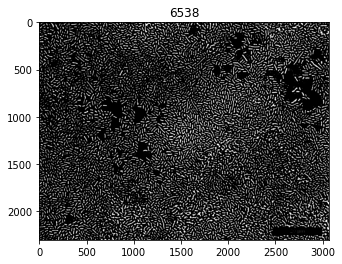

In [56]:
# mask = dp.binary_mask(imageBF3,0.65,k_size=3,iterations=2)
# contours = de.find_contours(mask3) # Obtains elements by contours
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(len(contours))
plt.imshow(mask3,cmap='gray')
# cv2.imwrite('CHA0_NYB_mask.png',mask)

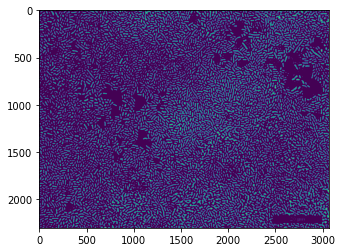

In [57]:
plt.imshow(mask3*imageBF3)
# cv2.imwrite('CHA0_NYB_withmask.png',mask*image2)

In [36]:
hist = plt.hist((mask*imageGFP3).ravel(),256,[5,255])[2]
# plt.savefig('CHA0_NYB_hist.png')

NameError: name 'mask' is not defined

In [6]:
path = '/media/leandro/Volumen1TB1/Lean/Patricio Sobrero/imagenes/'
imageBF1 = cv2.imread(path + '191022_CHA0_1_BF.tif')[:,:,1]
imageGFP1 = cv2.imread(path + '191022_CHA0_1_F.tif')[:,:,1]
imageBF2 = cv2.imread(path + '191022_CHA0_2_BF.tif')[:,:,1]
imageGFP2 = cv2.imread(path + '191022_CHA0_2_F.tif')[:,:,1]
imageBF3 = cv2.imread(path + '191022_CHA0_3_BF.tif')[:,:,1]
imageGFP3 = cv2.imread(path + '191022_CHA0_3_F.tif')[:,:,1]
mask1 = dp.binary_mask(imageBF1,0.65,k_size=3,iterations=2)/255
mask2 = dp.binary_mask(imageBF2,0.65,k_size=3,iterations=2)/255
mask3 = dp.binary_mask(imageBF3,0.65,k_size=3,iterations=2)/255
background_191022 = (mask1*imageGFP1).ravel()/(mask1*imageGFP1).ravel().mean() + (mask2*imageGFP2).ravel()/(mask2*imageGFP2).ravel().mean()# + (mask3*imageGFP3).ravel()/(mask3*imageGFP3).ravel().mean()

In [5]:
path = '/media/leandro/Volumen1TB1/Lean/Patricio Sobrero/imagenes/'
imageBF1 = cv2.imread(path + '201022_CHA0_1_BF.tif')[:,:,1]
imageGFP1 = cv2.imread(path + '201022_CHA0_1_F.tif')[:,:,1]
imageBF2 = cv2.imread(path + '201022_CHA0_2_BF.tif')[:,:,1]
imageGFP2 = cv2.imread(path + '201022_CHA0_2_F.tif')[:,:,1]
imageBF3 = cv2.imread(path + '201022_CHA0_3_BF.tif')[:,:,1]
imageGFP3 = cv2.imread(path + '201022_CHA0_3_F.tif')[:,:,1]
mask1 = dp.binary_mask(imageBF1,0.65,k_size=3,iterations=2)/255
mask2 = dp.binary_mask(imageBF2,0.65,k_size=3,iterations=2)/255
mask3 = dp.binary_mask(imageBF3,0.65,k_size=3,iterations=2)/255
background_201022 = (mask1*imageGFP1).ravel()/(mask1*imageGFP1).ravel().mean() + (mask2*imageGFP2).ravel()/(mask2*imageGFP2).ravel().mean()# + (mask3*imageGFP3).ravel()/(mask3*imageGFP3).ravel().mean()

In [131]:
# Importing library
from scipy.stats import skew,kurtosis,variation

# Calculate the skewness
print('skew = ', skew(data1-data, axis=0, bias=True))
# Calculate the kurtosis
print('kurtosis = ', kurtosis(data1-data, axis=0, bias=True))
print ("Coefficient of Variation = ", variation(data1-data, axis = 0))
with open(path+"CHA0_PorfR2.txt", "w") as text_file:
    text_file.write('skew = '+ str(skew(data1-data, axis=0, bias=True))+'\n'+
                   'kurtosis = '+ str(kurtosis(data1-data, axis=0, bias=True))+'\n'+
                   "Coefficient of Variation = "+ str(variation(data1-data, axis = 0)))

skew =  0.31310788869236467
kurtosis =  4.076170031993446
Coefficient of Variation =  7.532909042038437e+17


In [45]:
def crop_vertical(image_matrix, pixel_start, pixel_end):
    return image_matrix[pixel_start:pixel_end]


def crop_horizontal(image_matrix, pixel_start, pixel_end):
    return image_matrix[0:len(image_matrix), pixel_start:pixel_end]

path = '/media/leandro/Volumen1TB1/Alt Atlas/images/Human Embryonic Stem Cells and Human Induced Pluripotent Stem Cell Images/Human Embryonic Stem Cells/'
folder = os.listdir(path)
for photo in folder:
    if 'tif' in photo:
        if not os.path.exists(path + photo[:-4]):
            os.makedirs(path + photo[:-4])
        image = ui.readimages_asmatrix(path+photo)
        image = cv2.resize(image, dsize=(450, 350), interpolation=cv2.INTER_CUBIC)
        for i in range (0,image.shape[1],50):
            for j in range (0,image.shape[0],50):
                image_data = crop_horizontal(image, i, i+50)
                image_data = crop_vertical(image_data, j, j+50)
                cv2.imwrite(path + photo[:-4]  + '/' + photo+str(i)+'_'+str(j)+'.tif',image_data)

In [23]:
path = '/media/leandro/Volumen1TB1/Lean/Patricio Sobrero/'

dicc = {}
for fecha in ['191022','201022']:
    for cepa in ['CHA0','CHA19','CHA1009']:
        for promotor in ['21910','PblbC','PofaA','PorfR1','PorfR2','PrsmZ']:
            data_list = 0
            for imagen in ['F','BF']:
                for cel in range(1,4):
                    try:
                        image_name_GFP = fecha + '_' + cepa + '_' + promotor + '_' + str(cel) + '_' + 'F.tif'
                        image_name_BF = str(fecha) + '_' + cepa + '_' + str(promotor) + '_' + str(cel) + '_' + 'BF.tif'
                        imageGFP = cv2.imread(path + 'imagenes/' + image_name_GFP)[:,:,1]
                        imageBF = cv2.imread(path + 'imagenes/' + image_name_BF)[:,:,1]
                        mask = dp.binary_mask(imageBF,0.65,k_size=3,iterations=2)/255
                        data_norm = (mask*imageGFP).ravel()/(mask*imageGFP).ravel().mean()
                        data_list =+ data_norm
                    except:
                        pass
            dicc[str(fecha) + '_' + str(cepa) + '_' + str(promotor)] = data_list 
df_exp = pd.DataFrame(dicc.items(), columns=['exp', 'array'])

In [25]:
import itertools
back_list = list(itertools.repeat(background_191022, 36))

df_exp['background'] = back_list

In [26]:
df_exp['array_norm'] = df_exp['array'] - df_exp['background']

In [31]:
for i in df_exp['array_norm']:
    i.delete(0)

AttributeError: 'numpy.ndarray' object has no attribute 'delete'

In [267]:
df_exp['mediana'] = df[df_exp['array_norm']].median

In [27]:
df_exp

,exp,array,background,array_norm
0,191022_CHA0_21910,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,191022_CHA0_PblbC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,191022_CHA0_PofaA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,191022_CHA0_PorfR1,"[4.357001016201652, 4.4780288222072535, 4.5990...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.357001016201652, 4.4780288222072535, 4.5990..."
4,191022_CHA0_PorfR2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,191022_CHA0_PrsmZ,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,191022_CHA19_21910,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,191022_CHA19_PblbC,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,191022_CHA19_PofaA,"[5.238705333927231, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.238705333927231, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
9,191022_CHA19_PorfR1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [259]:
import scipy.stats as ss

t = range(36)
c = set(itertools.combinations(t, 2))
c
for combination in c:
    print(df_exp['exp'][combination[0]],df_exp['exp'][combination[1]],ss.kstest(df_exp['array_norm'][combination[0]], df_exp['array_norm'][combination[1]], args=(), N=7077888, alternative='two-sided'))

191022_CHA1009_PorfR1 201022_CHA0_PorfR1 KstestResult(statistic=0.018069938377097805, pvalue=0.0)
191022_CHA19_PblbC 191022_CHA1009_PrsmZ KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA1009_PorfR1 201022_CHA1009_21910 KstestResult(statistic=0.031515192102502865, pvalue=0.0)
201022_CHA19_PofaA 201022_CHA1009_21910 KstestResult(statistic=0.031366560194227455, pvalue=0.0)
191022_CHA19_PblbC 201022_CHA19_PofaA KstestResult(statistic=0.1254307782208478, pvalue=0.0)
201022_CHA0_21910 201022_CHA19_PofaA KstestResult(statistic=0.019634529396339695, pvalue=0.0)
191022_CHA19_PblbC 201022_CHA1009_PrsmZ KstestResult(statistic=0.0, pvalue=1.0)
201022_CHA0_21910 201022_CHA1009_PrsmZ KstestResult(statistic=0.12772185714156536, pvalue=0.0)
201022_CHA19_PrsmZ 201022_CHA1009_PofaA KstestResult(statistic=0.11176300048828125, pvalue=0.0)
191022_CHA19_PofaA 191022_CHA19_PorfR1 KstestResult(statistic=0.12771140204535592, pvalue=0.0)
191022_CHA0_21910 191022_CHA0_PrsmZ KstestResult(statistic=0.12570571899

191022_CHA1009_PofaA 201022_CHA0_21910 KstestResult(statistic=0.12772185714156536, pvalue=0.0)
191022_CHA1009_PrsmZ 201022_CHA0_PofaA KstestResult(statistic=0.10093844378436057, pvalue=0.0)
191022_CHA0_PrsmZ 201022_CHA19_PorfR1 KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA1009_PrsmZ 201022_CHA19_PrsmZ KstestResult(statistic=0.0, pvalue=1.0)
201022_CHA19_PorfR2 201022_CHA19_PrsmZ KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA19_PorfR1 201022_CHA19_PblbC KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA19_PorfR1 201022_CHA1009_PorfR2 KstestResult(statistic=0.11897687558774594, pvalue=0.0)
191022_CHA19_21910 191022_CHA19_PorfR2 KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA19_21910 201022_CHA0_PblbC KstestResult(statistic=0.15415926332826968, pvalue=0.0)
191022_CHA19_21910 201022_CHA19_PorfR2 KstestResult(statistic=0.0, pvalue=1.0)
201022_CHA19_PrsmZ 201022_CHA1009_21910 KstestResult(statistic=0.12397158587420432, pvalue=0.0)
201022_CHA0_PorfR1 201022_CHA19_PofaA KstestResul

191022_CHA1009_21910 201022_CHA19_PrsmZ KstestResult(statistic=0.12691201104058158, pvalue=0.0)
201022_CHA0_PrsmZ 201022_CHA19_PrsmZ KstestResult(statistic=0.11312159785517939, pvalue=0.0)
191022_CHA0_PorfR2 201022_CHA19_PblbC KstestResult(statistic=0.11896401864510997, pvalue=0.0)
191022_CHA0_PorfR2 201022_CHA1009_PorfR2 KstestResult(statistic=0.023732927110460045, pvalue=0.0)
191022_CHA0_PblbC 191022_CHA19_PorfR2 KstestResult(statistic=0.12364041363751443, pvalue=0.0)
191022_CHA0_PblbC 201022_CHA0_PblbC KstestResult(statistic=0.08884486445674189, pvalue=0.0)
191022_CHA1009_PblbC 201022_CHA0_PorfR1 KstestResult(statistic=0.029462602403428795, pvalue=0.0)
191022_CHA1009_PorfR2 191022_CHA1009_PrsmZ KstestResult(statistic=0.12879025494610818, pvalue=0.0)
191022_CHA0_PblbC 201022_CHA19_PorfR2 KstestResult(statistic=0.12364041363751443, pvalue=0.0)
191022_CHA1009_PblbC 201022_CHA1009_21910 KstestResult(statistic=0.02449968126085067, pvalue=0.0)
201022_CHA19_21910 201022_CHA1009_21910 Kstes

191022_CHA0_PorfR2 191022_CHA19_PorfR2 KstestResult(statistic=0.11896401864510997, pvalue=0.0)
191022_CHA1009_21910 201022_CHA0_PrsmZ KstestResult(statistic=0.040045420328776005, pvalue=0.0)
191022_CHA0_PorfR2 201022_CHA0_PblbC KstestResult(statistic=0.08172974763093177, pvalue=0.0)
191022_CHA0_PorfR2 201022_CHA19_PorfR2 KstestResult(statistic=0.11896401864510997, pvalue=0.0)
191022_CHA0_PblbC 191022_CHA0_PorfR2 KstestResult(statistic=0.012398755108868564, pvalue=0.0)
191022_CHA0_PblbC 191022_CHA1009_PblbC KstestResult(statistic=0.01771375868055558, pvalue=0.0)
191022_CHA0_PorfR1 201022_CHA1009_PofaA KstestResult(statistic=0.00915809913917831, pvalue=3.08332807163042e-258)
191022_CHA1009_PorfR1 201022_CHA19_21910 KstestResult(statistic=0.13250647650824654, pvalue=0.0)
191022_CHA19_PblbC 201022_CHA0_PofaA KstestResult(statistic=0.10093844378436057, pvalue=0.0)
201022_CHA0_21910 201022_CHA0_PofaA KstestResult(statistic=0.043981340196397656, pvalue=0.0)
191022_CHA1009_PorfR1 201022_CHA100

201022_CHA0_PorfR1 201022_CHA19_PblbC KstestResult(statistic=0.12289965594256369, pvalue=0.0)
191022_CHA0_21910 191022_CHA0_PofaA KstestResult(statistic=0.030355806703920685, pvalue=0.0)
201022_CHA0_PorfR1 201022_CHA1009_PorfR2 KstestResult(statistic=0.033380437780309635, pvalue=0.0)
191022_CHA19_PorfR2 191022_CHA1009_PorfR1 KstestResult(statistic=0.13250647650824654, pvalue=0.0)
191022_CHA19_PorfR2 201022_CHA19_21910 KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA0_PofaA 201022_CHA0_PofaA KstestResult(statistic=0.018372853597005245, pvalue=0.0)
191022_CHA19_PorfR2 201022_CHA1009_PorfR1 KstestResult(statistic=0.11759722674334494, pvalue=0.0)
201022_CHA1009_PorfR1 201022_CHA1009_PrsmZ KstestResult(statistic=0.11759722674334494, pvalue=0.0)
191022_CHA0_PofaA 201022_CHA19_PrsmZ KstestResult(statistic=0.11643685234917533, pvalue=0.0)
201022_CHA19_PblbC 201022_CHA1009_PblbC KstestResult(statistic=0.11640916047272853, pvalue=0.0)
191022_CHA0_PorfR1 191022_CHA1009_21910 KstestResult(statis

191022_CHA19_PorfR1 201022_CHA1009_PblbC KstestResult(statistic=0.11640916047272853, pvalue=0.0)
191022_CHA19_21910 191022_CHA19_PblbC KstestResult(statistic=0.0, pvalue=1.0)
191022_CHA19_21910 191022_CHA1009_PorfR2 KstestResult(statistic=0.12879025494610818, pvalue=0.0)
191022_CHA19_21910 201022_CHA19_PblbC KstestResult(statistic=0.0, pvalue=1.0)
201022_CHA0_PorfR1 201022_CHA0_PrsmZ KstestResult(statistic=0.010159386528862835, pvalue=1.0777133e-317)
201022_CHA0_PofaA 201022_CHA19_PorfR1 KstestResult(statistic=0.10093844378436057, pvalue=0.0)
191022_CHA19_PorfR2 191022_CHA1009_PblbC KstestResult(statistic=0.11891838356300632, pvalue=0.0)
191022_CHA1009_21910 201022_CHA1009_PofaA KstestResult(statistic=0.043627562346281734, pvalue=0.0)
201022_CHA0_PrsmZ 201022_CHA1009_PofaA KstestResult(statistic=0.00912984212239576, pvalue=1.195358882898153e-256)
191022_CHA0_PofaA 191022_CHA19_PorfR1 KstestResult(statistic=0.11643685234917533, pvalue=0.0)
191022_CHA0_PofaA 201022_CHA0_21910 KstestResul

201022_CHA0_PofaA 201022_CHA0_PorfR1 KstestResult(statistic=0.02489245379412619, pvalue=0.0)
191022_CHA1009_21910 191022_CHA1009_PrsmZ KstestResult(statistic=0.12691201104058158, pvalue=0.0)
201022_CHA0_PofaA 201022_CHA1009_21910 KstestResult(statistic=0.041685175012659226, pvalue=0.0)
191022_CHA0_PorfR2 191022_CHA1009_PblbC KstestResult(statistic=0.019501156277126785, pvalue=0.0)
191022_CHA1009_21910 201022_CHA19_PofaA KstestResult(statistic=0.07204790468569156, pvalue=0.0)
201022_CHA0_PrsmZ 201022_CHA19_PofaA KstestResult(statistic=0.034745816831235454, pvalue=0.0)
191022_CHA0_PorfR2 201022_CHA0_PorfR2 KstestResult(statistic=0.017751199227792225, pvalue=0.0)
191022_CHA1009_21910 201022_CHA1009_PrsmZ KstestResult(statistic=0.12691201104058158, pvalue=0.0)
201022_CHA0_PrsmZ 201022_CHA1009_PrsmZ KstestResult(statistic=0.11312159785517939, pvalue=0.0)
191022_CHA0_PorfR2 201022_CHA1009_PblbC KstestResult(statistic=0.006244376853660305, pvalue=2.7634270797380478e-120)
191022_CHA0_PblbC 191

191022_CHA19_PrsmZ 201022_CHA19_PorfR2 KstestResult(statistic=0.0, pvalue=1.0)
201022_CHA1009_PorfR1 201022_CHA1009_PorfR2 KstestResult(statistic=0.02814653184678817, pvalue=0.0)
201022_CHA19_PblbC 201022_CHA1009_21910 KstestResult(statistic=0.12397158587420432, pvalue=0.0)
191022_CHA0_PorfR2 191022_CHA19_PblbC KstestResult(statistic=0.11896401864510997, pvalue=0.0)
191022_CHA0_PorfR2 191022_CHA1009_PorfR2 KstestResult(statistic=0.010906502052589695, pvalue=0.0)
201022_CHA0_PorfR2 201022_CHA19_21910 KstestResult(statistic=0.11804863258644382, pvalue=0.0)
191022_CHA0_PorfR1 201022_CHA0_PofaA KstestResult(statistic=0.02697217022931131, pvalue=0.0)
191022_CHA1009_PofaA 201022_CHA0_PofaA KstestResult(statistic=0.10093844378436057, pvalue=0.0)
201022_CHA0_PorfR2 201022_CHA1009_PorfR1 KstestResult(statistic=0.01855242693865744, pvalue=0.0)
201022_CHA1009_PorfR2 201022_CHA1009_PrsmZ KstestResult(statistic=0.11897687558774594, pvalue=0.0)
191022_CHA0_PorfR1 201022_CHA19_PrsmZ KstestResult(stat